In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

In [2]:
def load_data(folder):
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            label = filename.split('.')[0]  # Filename is the label
            img_path = os.path.join(folder, filename)
            
            # Read Image (Grayscale)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img / 255.0  # Normalize
            
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [3]:
image_folder = "samples"
X, y = load_data(image_folder)

In [4]:
X = X.reshape(-1, 50, 200, 1)

In [5]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)

In [6]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(encoded_labels)), activation='softmax')  # Number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 198, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 48, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 33792)             0         
                                                                 
 dense (Dense)               (None, 128)               4

In [7]:
history = model.fit(X, encoded_labels, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
27/27 [==============================] - 5s 146ms/step - loss: 6.9977 - accuracy: 0.0000e+00 - val_loss: 6.9882 - val_accuracy: 0.0000e+00
Epoch 2/15
27/27 [==============================] - 4s 141ms/step - loss: 6.9707 - accuracy: 0.0000e+00 - val_loss: 7.0190 - val_accuracy: 0.0000e+00
Epoch 3/15
27/27 [==============================] - 4s 155ms/step - loss: 6.9652 - accuracy: 0.0012 - val_loss: 7.0492 - val_accuracy: 0.0000e+00
Epoch 4/15
27/27 [==============================] - 4s 163ms/step - loss: 6.9358 - accuracy: 0.0023 - val_loss: 7.2860 - val_accuracy: 0.0000e+00
Epoch 5/15
27/27 [==============================] - 4s 156ms/step - loss: 6.8592 - accuracy: 0.0012 - val_loss: 7.8406 - val_accuracy: 0.0000e+00
Epoch 6/15
27/27 [==============================] - 4s 161ms/step - loss: 6.6764 - accuracy: 0.0082 - val_loss: 8.6310 - val_accuracy: 0.0000e+00
Epoch 7/15
27/27 [==============================] - 4s 163ms/step - loss: 6.0934 - accuracy: 0.0397 - val_loss: 10.7

In [8]:
def predict(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Image not found at:", image_path)
        return "Error"

    img = img / 255.0
    img = img.reshape(1, img.shape[0], img.shape[1], 1)

    prediction = model.predict(img)
    index = np.argmax(prediction)
    captcha_text = label_encoder.inverse_transform([index])

    return captcha_text[0]


In [9]:
test_image = "samples/2cg58.png"
print("Prediction:", predict(test_image))

1/1 [==============================] - 0s 138ms/step
Prediction: 2cg58


Baseline accuracy on test data: 0.8178

Testing with epsilon = 0
Accuracy on adversarial examples: 0.8178

Testing with epsilon = 0.01
Accuracy on adversarial examples: 0.8178

Testing with epsilon = 0.05
Accuracy on adversarial examples: 0.7757

Testing with epsilon = 0.1
Accuracy on adversarial examples: 0.1308

Testing with epsilon = 0.15
Accuracy on adversarial examples: 0.0280

Testing with epsilon = 0.2
Accuracy on adversarial examples: 0.0140

Testing with epsilon = 0.25
Accuracy on adversarial examples: 0.0093


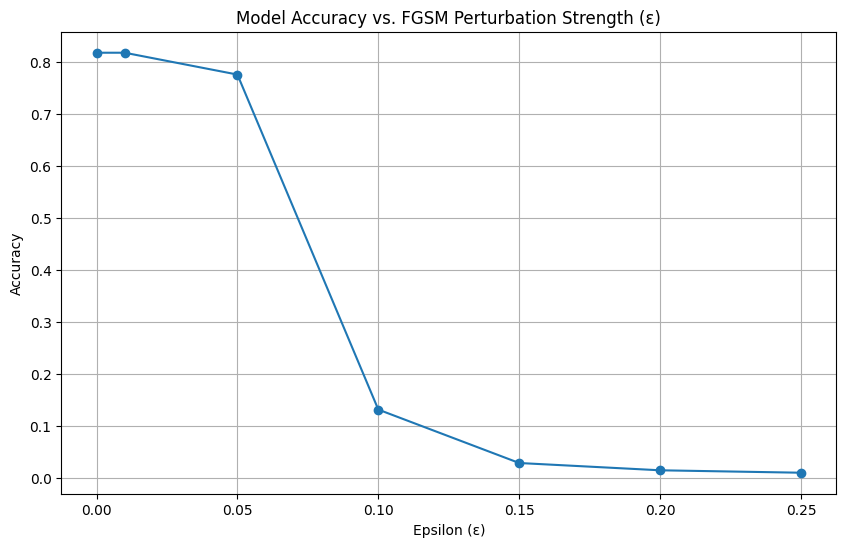

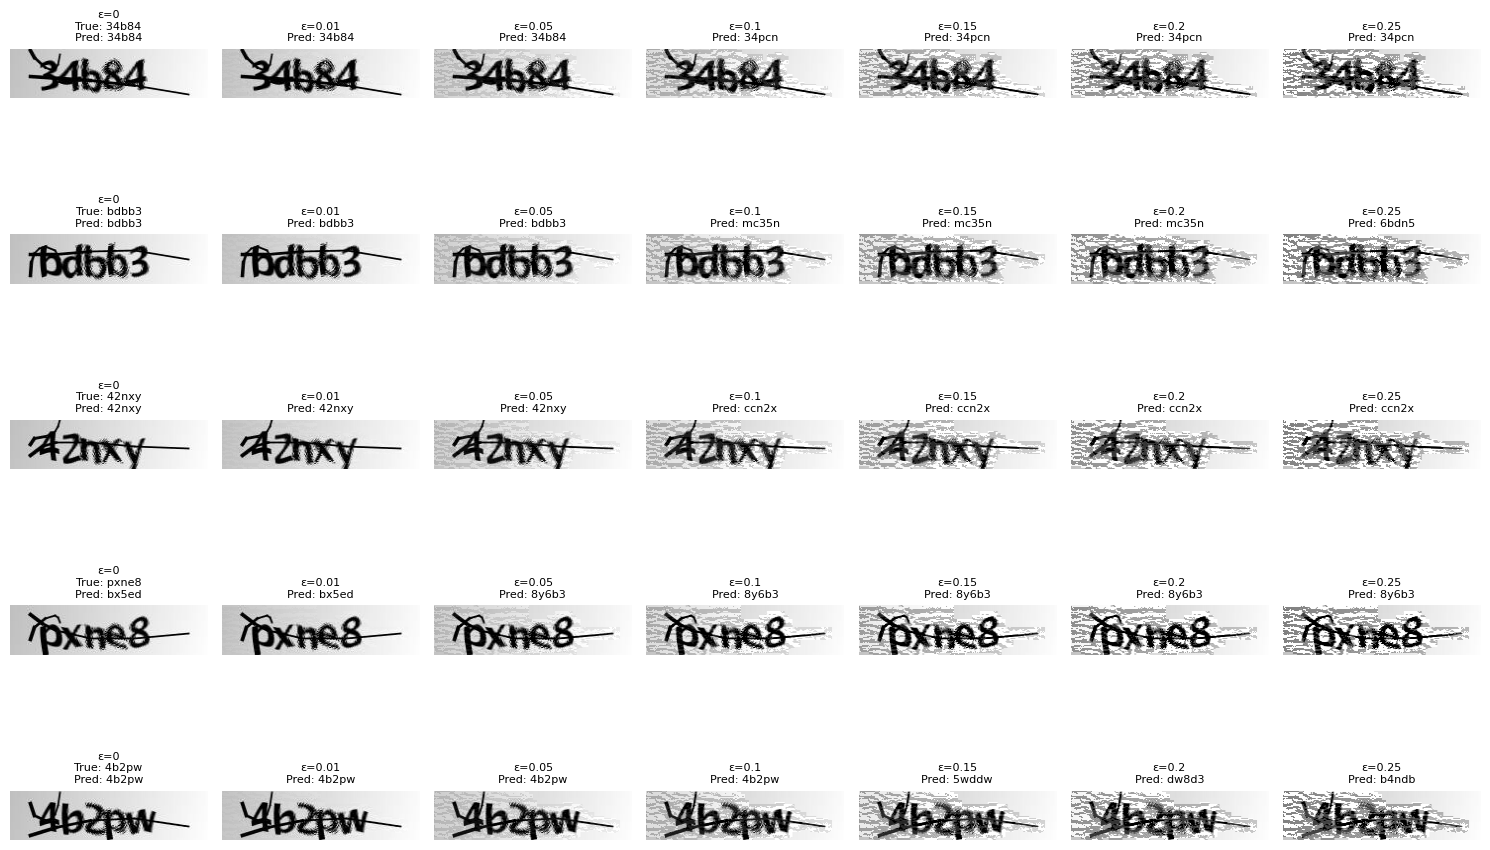

In [10]:
# ... existing code ...

# Add after the label encoder saving cell
import matplotlib.pyplot as plt
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def create_adversarial_pattern(input_image, input_label):
    """
    Creates the adversarial pattern using FGSM
    """
    input_image = tf.convert_to_tensor(input_image)
    input_label = tf.convert_to_tensor(input_label)
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = SparseCategoricalCrossentropy()(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image
    gradient = tape.gradient(loss, input_image)
    
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

def apply_fgsm_attack(image, label, epsilon):
    """
    Applies FGSM attack with given epsilon
    """
    # Get the adversarial pattern
    perturbations = create_adversarial_pattern(image, label)
    
    # Create the adversarial example
    adv_image = image + epsilon * perturbations
    
    # Make sure the image is still in [0, 1]
    adv_image = tf.clip_by_value(adv_image, 0, 1)
    
    return adv_image

# Load test data (using a portion of the original data as test)
# We'll use the validation split from the original dataset
test_indices = np.random.choice(len(X), size=int(0.2*len(X)), replace=False)
X_test = X[test_indices]
y_test = encoded_labels[test_indices]

# Calculate baseline accuracy
baseline_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Baseline accuracy on test data: {baseline_accuracy:.4f}")

# Test different epsilon values
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
accuracies = []

for epsilon in epsilons:
    print(f"\nTesting with epsilon = {epsilon}")
    
    # Create adversarial examples for the test set
    adv_examples = []
    for i in range(len(X_test)):
        adv_example = apply_fgsm_attack(X_test[i:i+1], y_test[i:i+1], epsilon)
        adv_examples.append(adv_example)
    
    adv_examples = tf.concat(adv_examples, axis=0)
    
    # Evaluate model on adversarial examples
    _, accuracy = model.evaluate(adv_examples, y_test, verbose=0)
    print(f"Accuracy on adversarial examples: {accuracy:.4f}")
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, marker='o')
plt.title('Model Accuracy vs. FGSM Perturbation Strength (ε)')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('fgsm_accuracy_plot.png')
plt.show()

# Visualize some examples
plt.figure(figsize=(15, 10))
num_examples = 5
random_indices = np.random.choice(len(X_test), size=num_examples, replace=False)

for i, idx in enumerate(random_indices):
    original_img = X_test[idx]
    label = y_test[idx]
    
    # Create adversarial examples with different epsilons
    for j, eps in enumerate(epsilons):
        plt.subplot(num_examples, len(epsilons), i*len(epsilons) + j + 1)
        
        if eps == 0:
            # Original image
            plt.imshow(original_img.reshape(50, 200), cmap='gray')
            pred = np.argmax(model.predict(original_img.reshape(1, 50, 200, 1), verbose=0))
            title = f"ε=0\nTrue: {label_encoder.inverse_transform([label])[0]}\nPred: {label_encoder.inverse_transform([pred])[0]}"
        else:
            # Adversarial image
            adv_img = apply_fgsm_attack(original_img.reshape(1, 50, 200, 1), np.array([label]), eps)
            plt.imshow(adv_img[0].numpy().reshape(50, 200), cmap='gray')
            pred = np.argmax(model.predict(adv_img, verbose=0))
            title = f"ε={eps}\nPred: {label_encoder.inverse_transform([pred])[0]}"
        
        plt.title(title, fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.savefig('fgsm_examples.png')
plt.show()


Generating confusion matrix for epsilon = 0

Generating confusion matrix for epsilon = 0.01

Generating confusion matrix for epsilon = 0.05

Generating confusion matrix for epsilon = 0.1

Generating confusion matrix for epsilon = 0.15

Generating confusion matrix for epsilon = 0.2

Generating confusion matrix for epsilon = 0.25


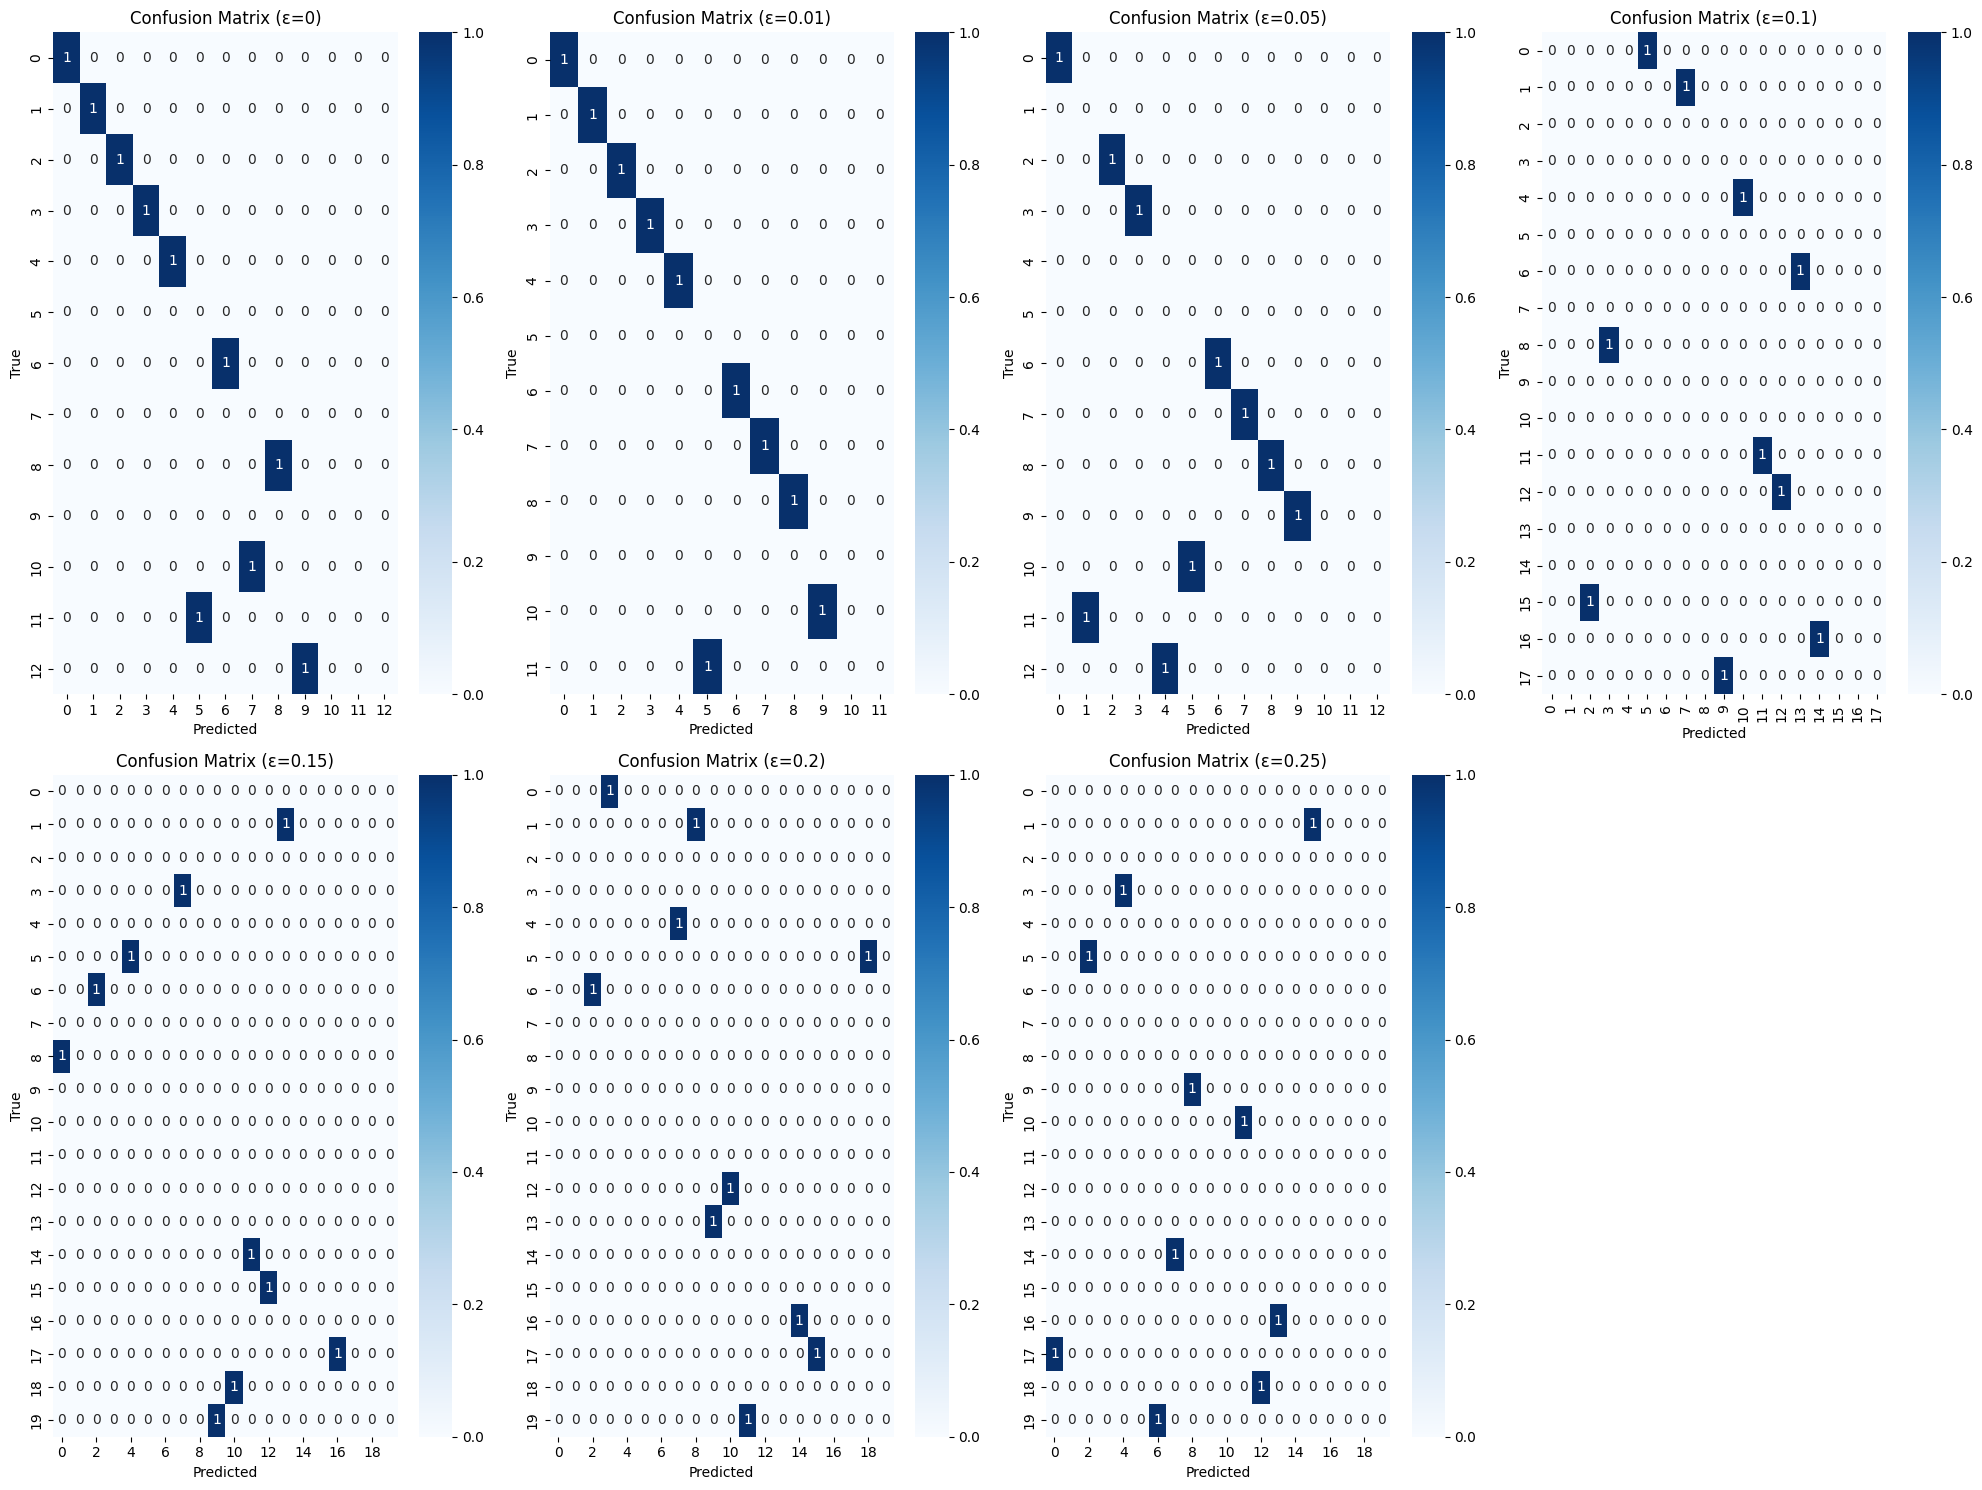

In [12]:
# After the accuracy plot and before the example visualization

# Add confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(20, 15))
for i, epsilon in enumerate(epsilons):
    print(f"\nGenerating confusion matrix for epsilon = {epsilon}")
    
    # Select only 10 random samples for the confusion matrix
    sample_indices = np.random.choice(len(X_test), size=10, replace=False)
    X_sample = X_test[sample_indices]
    y_sample = y_test[sample_indices]
    
    # Create adversarial examples for the sampled test set
    adv_examples = []
    for j in range(len(X_sample)):
        adv_example = apply_fgsm_attack(X_sample[j:j+1], y_sample[j:j+1], epsilon)
        adv_examples.append(adv_example)
    
    adv_examples = tf.concat(adv_examples, axis=0)
    
    # Get predictions
    predictions = model.predict(adv_examples, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    
    # Create confusion matrix
    cm = confusion_matrix(y_sample, y_pred)
    
    # Plot confusion matrix
    plt.subplot(2, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (ε={epsilon})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
plt.tight_layout()
plt.savefig('fgsm_confusion_matrices.png')
plt.show()

# Continue with the existing example visualization code


Testing PGD with epsilon = 0
Accuracy on PGD adversarial examples: 0.8178

Testing PGD with epsilon = 0.01
Accuracy on PGD adversarial examples: 0.8178

Testing PGD with epsilon = 0.05
Accuracy on PGD adversarial examples: 0.5467

Testing PGD with epsilon = 0.1
Accuracy on PGD adversarial examples: 0.0140

Testing PGD with epsilon = 0.15
Accuracy on PGD adversarial examples: 0.0140

Testing PGD with epsilon = 0.2
Accuracy on PGD adversarial examples: 0.0140

Testing PGD with epsilon = 0.25
Accuracy on PGD adversarial examples: 0.0140


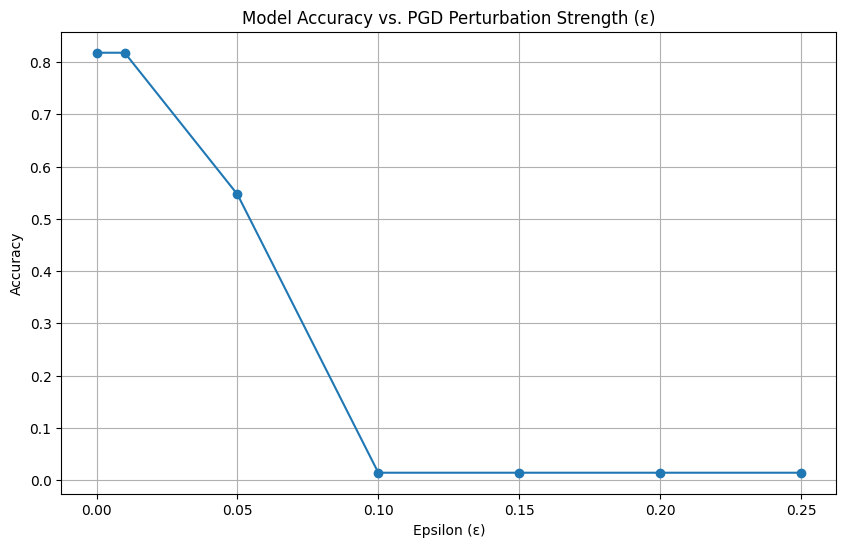

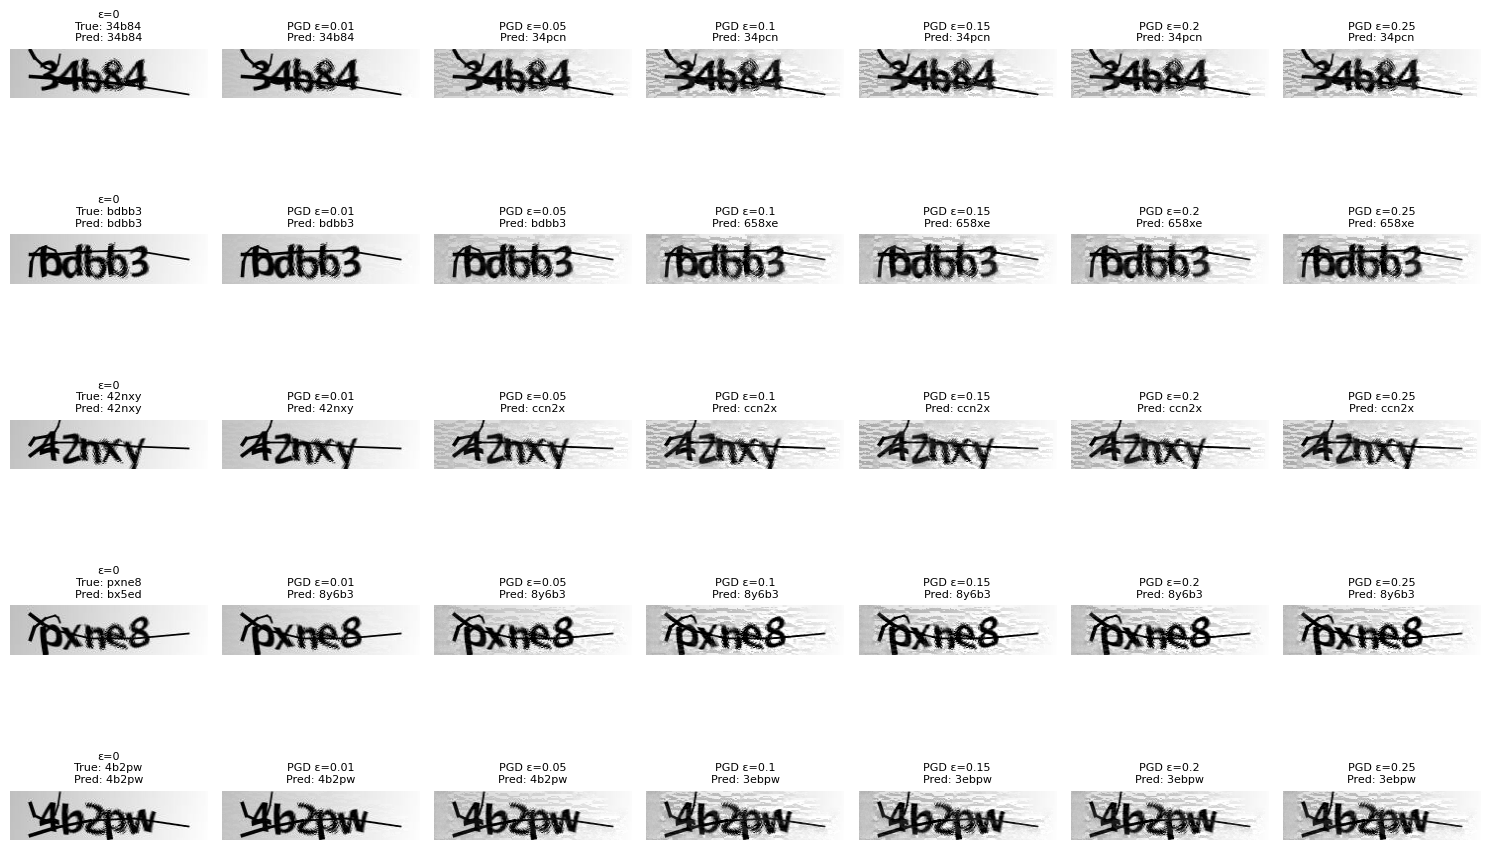

In [23]:
# ... existing code ...
import matplotlib.pyplot as plt
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf # Ensure tensorflow is imported
import numpy as np # Ensure numpy is imported

# Keep this function as it calculates the gradient needed for each PGD step
def create_adversarial_pattern(input_image, input_label, model):
    """
    Calculates the sign of the gradient of the loss w.r.t. the input image.
    """
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)
    input_label = tf.convert_to_tensor(input_label)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        # Ensure labels have the correct shape if they are single integers
        if len(input_label.shape) == 1:
             input_label = tf.expand_dims(input_label, axis=0)
        loss = SparseCategoricalCrossentropy()(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image
    gradient = tape.gradient(loss, input_image)

    # Get the sign of the gradients to create the perturbation direction
    signed_grad = tf.sign(gradient)
    return signed_grad

# Define the PGD attack function
def apply_pgd_attack(image, label, model, epsilon, alpha, num_iter):
    """
    Applies PGD attack with given parameters.
    """
    # Start with the original image
    adv_image = tf.identity(image)
    original_image = tf.identity(image) # Keep original for projection

    for _ in range(num_iter):
        # Calculate the gradient sign
        signed_grad = create_adversarial_pattern(adv_image, label, model)

        # Update the adversarial image
        adv_image = adv_image + alpha * signed_grad

        # Project the perturbation back into the epsilon-ball around the original image
        perturbation = tf.clip_by_value(adv_image - original_image, -epsilon, epsilon)
        adv_image = original_image + perturbation

        # Clip the image to ensure it remains in the valid [0, 1] range
        adv_image = tf.clip_by_value(adv_image, 0, 1)

    return adv_image

alpha = 0.01  # Step size for each iteration
num_iter = 10 # Number of iterations for PGD

# Test different epsilon values
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
accuracies = []

for epsilon in epsilons:
    print(f"\nTesting PGD with epsilon = {epsilon}")

    # Create adversarial examples for the test set using PGD
    adv_examples = []
    # Process in batches if the dataset is large to avoid memory issues
    batch_size = 32 # Adjust as needed
    num_batches = int(np.ceil(len(X_test) / batch_size))

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X_test))
        batch_images = X_test[start_idx:end_idx]
        batch_labels = y_test[start_idx:end_idx]

        # Ensure batch_images is a tf.Tensor for the attack function
        batch_images_tf = tf.convert_to_tensor(batch_images, dtype=tf.float32)

        batch_adv_examples = []
        for j in range(len(batch_images_tf)):
             # Ensure label is passed correctly (e.g., as a single element tensor/array)
             current_label = tf.convert_to_tensor([batch_labels[j]], dtype=tf.int64)
             current_image = tf.expand_dims(batch_images_tf[j], axis=0) # Add batch dim

             adv_example = apply_pgd_attack(current_image, current_label, model, epsilon, alpha, num_iter)
             batch_adv_examples.append(adv_example)

        if batch_adv_examples: # Check if the list is not empty
             adv_examples.append(tf.concat(batch_adv_examples, axis=0))


    if not adv_examples:
         print("Warning: No adversarial examples were generated.")
         accuracies.append(0) # Or handle as appropriate
         continue

    adv_examples = tf.concat(adv_examples, axis=0)

    # Evaluate model on adversarial examples
    _, accuracy = model.evaluate(adv_examples, y_test, verbose=0)
    print(f"Accuracy on PGD adversarial examples: {accuracy:.4f}")
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, marker='o')
plt.title('Model Accuracy vs. PGD Perturbation Strength (ε)') # Updated title
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('pgd_accuracy_plot.png') # Updated filename
plt.show()

# Visualize some examples
plt.figure(figsize=(15, 10))
num_examples = 5

for i, idx in enumerate(random_indices):
    original_img = X_test[idx]
    original_img_reshaped = original_img # Assuming X_test already has correct shape

    label = y_test[idx]

    # Create adversarial examples with different epsilons using PGD
    for j, eps in enumerate(epsilons):
        plt.subplot(num_examples, len(epsilons), i*len(epsilons) + j + 1)

        # Prepare image and label for attack function (add batch dim)
        current_image_tf = tf.convert_to_tensor(np.expand_dims(original_img_reshaped, axis=0), dtype=tf.float32)
        current_label_tf = tf.convert_to_tensor([label], dtype=tf.int64)


        if eps == 0:
            # Original image
            plt.imshow(original_img_reshaped.squeeze(), cmap='gray') # Use squeeze() to remove single channel dim for imshow
            # Ensure model expects batch dimension
            pred_input = tf.expand_dims(original_img_reshaped, axis=0)
            pred = np.argmax(model.predict(pred_input, verbose=0))
            title = f"ε=0\nTrue: {label_encoder.inverse_transform([label])[0]}\nPred: {label_encoder.inverse_transform([pred])[0]}"
        else:
            # Adversarial image using PGD
            adv_img = apply_pgd_attack(current_image_tf, current_label_tf, model, eps, alpha, num_iter)
            plt.imshow(adv_img[0].numpy().squeeze(), cmap='gray') # Squeeze for imshow
            pred = np.argmax(model.predict(adv_img, verbose=0))
            title = f"PGD ε={eps}\nPred: {label_encoder.inverse_transform([pred])[0]}" # Updated title

        plt.title(title, fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.savefig('pgd_examples.png') # Updated filename
plt.show()

# ... potentially more code ...

Label encoder loaded successfully from c:\Users\palla\Documents\techproj advattack\label_encoder.pkl
Label encoder classes (sample): ['226md' '22d5n' '2356g' '23mdg' '23n88']...

Testing C&W L2 Attack
Parameters: confidence=0.0, lr=0.01, bin_steps=9, max_iter=1000, initial_c=0.01
Processing 20 samples...
Finished processing. Attacked 16 samples.

Evaluating accuracy on 16 adversarial examples...
Loss on C&W adversarial examples: 0.0004
Accuracy on C&W adversarial examples (for originally correct samples): 1.0000
C&W Attack Success Rate: 0.0000 (0/16)

Generating visualizations for 5 examples...


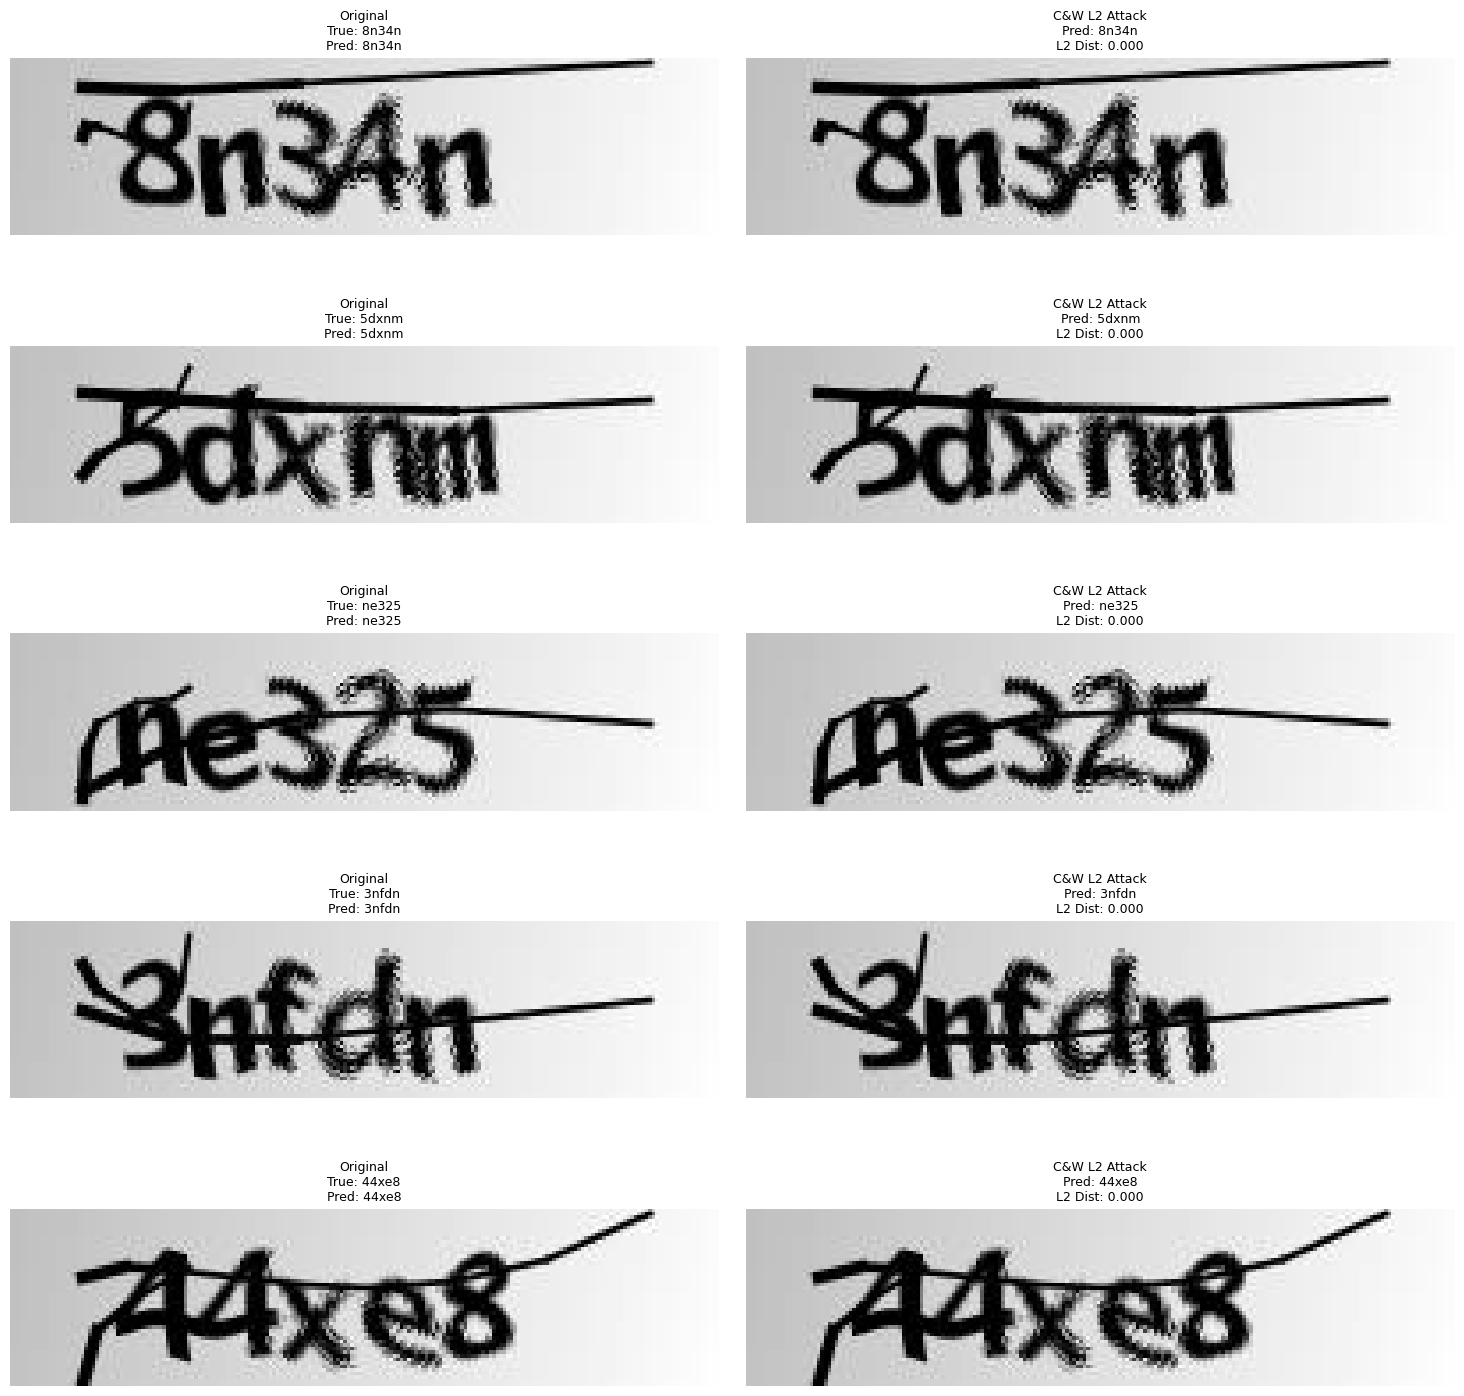


C&W Attack analysis complete.


In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import joblib # Or import pickle
import os
import cv2 # Keep cv2 import if needed elsewhere, though not directly in this block
from tensorflow.keras.losses import CategoricalCrossentropy

# --- Load the Saved Label Encoder ---
label_encoder_path = r'c:\Users\palla\Documents\techproj advattack\label_encoder.pkl'
try:
    label_encoder = joblib.load(label_encoder_path)
    print(f"Label encoder loaded successfully from {label_encoder_path}")
    # Print some classes to verify
    print(f"Label encoder classes (sample): {label_encoder.classes_[:5]}...")
except FileNotFoundError:
    print(f"ERROR: Label encoder file not found at {label_encoder_path}. Please ensure it was saved correctly.")
    # Handle the error appropriately, maybe stop execution or raise an exception
    raise SystemExit("Label encoder not found.")
except Exception as e:
    print(f"ERROR: Failed to load label encoder. Error: {e}")
    raise SystemExit("Label encoder loading failed.")

# --- Define the Carlini & Wagner L2 Attack Function ---
# Note: Modified loss to work with softmax output (from_logits=False)
def apply_cw_l2_attack(model, image, label_one_hot, c_value, confidence, learning_rate, binary_search_steps, max_iterations):
    """
    Applies the Carlini & Wagner L2 attack (untargeted).
    Args:
        model: The trained Keras model (outputting probabilities/softmax).
        image: The input image (Tensor, shape [1, H, W, C]).
        label_one_hot: The true label, one-hot encoded (Tensor, shape [1, num_classes]).
        c_value: The constant 'c' balancing loss terms.
        confidence: The desired confidence kappa for misclassification.
        learning_rate: Learning rate for the optimizer.
        binary_search_steps: Number of steps for binary searching 'c'.
        max_iterations: Max iterations for the optimization within each binary search step.
    Returns:
        The adversarial image (Tensor, shape [1, H, W, C]).
    """
    original_image = tf.identity(image)
    num_classes = label_one_hot.shape[1]

    # Variable for the perturbation in arctanh space
    image_atanh = tf.atanh((image * 2.0 - 1.0) * 0.999999)
    modifier = tf.Variable(tf.zeros_like(image_atanh), dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    best_adv_image = None
    best_l2_distortion = float('inf')

    # Binary search for the constant 'c'
    lower_bound_c = 0.0
    upper_bound_c = 1e10
    current_c = c_value

    for binary_step in range(binary_search_steps):
        modifier.assign(tf.zeros_like(image_atanh))
        found_adv_at_this_c = False

        for iteration in range(max_iterations):
            with tf.GradientTape() as tape:
                tape.watch(modifier)
                # Transform modifier back to image space [0, 1]
                perturbed_image_normalized = tf.tanh(image_atanh + modifier) / 2.0 + 0.5
                l2_distortion = tf.reduce_sum(tf.square(perturbed_image_normalized - original_image))

                # Get model probabilities (softmax output)
                probabilities = model(perturbed_image_normalized)

                # Calculate C&W loss term f(x') using probabilities
                # Need log-probabilities (logits approximation) for stability if using CCE directly
                # Alternative: Directly use the C&W loss formulation with probabilities
                true_label_prob = tf.reduce_sum(label_one_hot * probabilities, axis=1)
                other_prob_max = tf.reduce_max((1.0 - label_one_hot) * probabilities - (label_one_hot * 10000.0), axis=1) # Max prob of non-true classes

                # Loss term: max(0, max_{i!=t}(Z(x')_i) - Z(x')_t + kappa)
                # We use probabilities here, which is slightly different but common
                # Add small epsilon to avoid log(0) if needed, though max should handle it
                f_loss = tf.maximum(0.0, other_prob_max - true_label_prob + confidence) # Confidence is kappa

                # Total loss = c * f(x') + ||delta||_2^2
                total_loss = current_c * f_loss + l2_distortion

            gradients = tape.gradient(total_loss, modifier)
            optimizer.apply_gradients([(gradients, modifier)])

            # Check if current perturbation creates a successful adversarial example
            current_perturbed_image_eval = tf.tanh(image_atanh + modifier) / 2.0 + 0.5
            current_probs_eval = model(current_perturbed_image_eval)
            current_pred_index = tf.argmax(current_probs_eval, axis=1)[0]
            true_label_index = tf.argmax(label_one_hot, axis=1)[0]

            if current_pred_index != true_label_index:
                 found_adv_at_this_c = True
                 current_l2_distortion = l2_distortion.numpy()
                 if current_l2_distortion < best_l2_distortion:
                     best_l2_distortion = current_l2_distortion
                     best_adv_image = current_perturbed_image_eval # Store the best image found so far

        # Update 'c' based on binary search result
        if found_adv_at_this_c:
            upper_bound_c = min(upper_bound_c, current_c)
            if upper_bound_c < 1e9:
                current_c = (lower_bound_c + upper_bound_c) / 2.0
        else:
            lower_bound_c = max(lower_bound_c, current_c)
            if upper_bound_c < 1e9:
                 current_c = (lower_bound_c + upper_bound_c) / 2.0
            else:
                 current_c *= 10

        # Optional: print progress
        # print(f"  Binary Step {binary_step+1}: c={current_c:.4e}, Found Adv={found_adv_at_this_c}, Best L2={best_l2_distortion:.4f}")

    if best_adv_image is None:
        # print(f"Warning: C&W attack failed for this image. Returning original.")
        return original_image

    return best_adv_image


# --- C&W Attack Execution and Evaluation ---

# Define C&W parameters
cw_confidence = 0.0     # Kappa: 0 for standard untargeted attack
cw_learning_rate = 0.01 # Common LR for Adam in C&W
cw_binary_search_steps = 9 # Standard number of steps
cw_max_iterations = 1000 # Increased significantly based on C&W paper (was 100)
initial_c = 0.01        # Reasonable initial value for c

print(f"\nTesting C&W L2 Attack")
# Updated print statement to reflect new parameters
print(f"Parameters: confidence={cw_confidence}, lr={cw_learning_rate}, bin_steps={cw_binary_search_steps}, max_iter={cw_max_iterations}, initial_c={initial_c}")
# Use the full dataset or a sample
# Using a small sample for demonstration due to C&W's slowness
num_test_samples = 20 # <<< ADJUST THIS NUMBER (e.g., 10, 50, 100)
if num_test_samples > len(X):
    num_test_samples = len(X)
    print(f"Warning: Requested more samples than available. Using {num_test_samples} samples.")

# Ensure X and encoded_labels are the full datasets loaded earlier
test_indices = np.random.choice(len(X), size=num_test_samples, replace=False)
X_test_sample = X[test_indices]
y_test_sample_int = encoded_labels[test_indices] # Use the integer labels loaded previously

# Get the number of classes from the loaded label encoder
num_classes = len(label_encoder.classes_)
y_test_sample_one_hot = tf.keras.utils.to_categorical(y_test_sample_int, num_classes=num_classes)

adv_examples_cw = []
successful_attacks = 0
total_processed = 0
processed_indices_in_sample = [] # Track indices *within the sample* that were processed

print(f"Processing {num_test_samples} samples...")
for i in range(num_test_samples):
    # print(f"Processing sample {i+1}/{num_test_samples} (Original Index: {test_indices[i]})...")
    img = X_test_sample[i:i+1] # Keep batch dimension
    label_one_hot = y_test_sample_one_hot[i:i+1] # Keep batch dimension
    true_label_int = y_test_sample_int[i] # Integer label for comparison

    # Ensure image is float32 tensor
    img_tf = tf.convert_to_tensor(img, dtype=tf.float32)

    # Check if the model already misclassifies the original image
    original_pred_probs = model.predict(img_tf, verbose=0)
    original_pred_int = np.argmax(original_pred_probs, axis=1)[0]

    if original_pred_int != true_label_int:
        # print(f"  Skipping sample {i+1}: Already misclassified (True: {true_label_int}, Pred: {original_pred_int}).")
        continue # Skip attack if already misclassified

    # If correctly classified, proceed with the attack
    total_processed += 1
    processed_indices_in_sample.append(i) # Store the index within the *sample* array

    adv_example = apply_cw_l2_attack(model, img_tf, label_one_hot, initial_c, cw_confidence, cw_learning_rate, cw_binary_search_steps, cw_max_iterations)
    adv_examples_cw.append(adv_example)

    # Check if the attack was successful
    adv_pred_probs = model.predict(adv_example, verbose=0)
    adv_pred_int = np.argmax(adv_pred_probs, axis=1)[0]
    if adv_pred_int != true_label_int:
        successful_attacks += 1
        # print(f"  Attack successful: True={true_label_int}, Orig Pred={original_pred_int}, Adv Pred={adv_pred_int}")
    # else:
        # print(f"  Attack failed: True={true_label_int}, Orig Pred={original_pred_int}, Adv Pred={adv_pred_int}")

print(f"Finished processing. Attacked {total_processed} samples.")

# Evaluate accuracy only on the samples that were initially classified correctly
if not adv_examples_cw:
     print("\nWarning: No adversarial examples were generated (all samples skipped or attack failed).")
elif total_processed == 0:
     print("\nWarning: All tested samples were already misclassified by the model. No attacks performed.")
else:
    adv_examples_cw_tensor = tf.concat(adv_examples_cw, axis=0)
    # Select the corresponding true labels for the processed samples
    y_test_processed_int = y_test_sample_int[processed_indices_in_sample]

    print(f"\nEvaluating accuracy on {total_processed} adversarial examples...")
    # Use sparse categorical accuracy since model expects integer labels for evaluation
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    test_loss_metric = tf.keras.metrics.Mean()

    # Manual evaluation loop if model.evaluate needs sparse labels
    dataset_adv = tf.data.Dataset.from_tensor_slices((adv_examples_cw_tensor, y_test_processed_int)).batch(32)
    for x_batch, y_batch in dataset_adv:
        predictions = model(x_batch, training=False)
        loss = loss_object(y_batch, predictions)
        test_acc_metric.update_state(y_batch, predictions)
        test_loss_metric.update_state(loss)

    accuracy_cw = test_acc_metric.result().numpy()
    loss_cw = test_loss_metric.result().numpy()

    print(f"Loss on C&W adversarial examples: {loss_cw:.4f}")
    print(f"Accuracy on C&W adversarial examples (for originally correct samples): {accuracy_cw:.4f}")
    attack_success_rate = successful_attacks / total_processed
    print(f"C&W Attack Success Rate: {attack_success_rate:.4f} ({successful_attacks}/{total_processed})")


# --- Visualization Section ---
num_examples_to_show = min(5, total_processed if total_processed > 0 else 0) # Show up to 5 successful/attempted examples
print(f"\nGenerating visualizations for {num_examples_to_show} examples...")

if num_examples_to_show > 0:
    plt.figure(figsize=(15, 3 * num_examples_to_show))

    # Select indices from the *processed* samples for visualization
    vis_indices_in_sample = np.random.choice(processed_indices_in_sample, size=num_examples_to_show, replace=False)

    for i, sample_idx in enumerate(vis_indices_in_sample):
        # Get original image and label using the index within the sample
        original_img = X_test_sample[sample_idx]
        true_label_int = y_test_sample_int[sample_idx]
        true_label_str = label_encoder.inverse_transform([true_label_int])[0]

        # Find the corresponding adversarial image (already generated)
        # Need to map sample_idx back to its position in adv_examples_cw
        original_pos_in_processed = list(processed_indices_in_sample).index(sample_idx)
        adv_img_tensor = adv_examples_cw[original_pos_in_processed] # Get the tensor
        adv_img_np = adv_img_tensor.numpy().squeeze() # Convert to numpy for imshow

        # --- Original Image ---
        plt.subplot(num_examples_to_show, 2, i*2 + 1)
        plt.imshow(original_img.squeeze(), cmap='gray')
        original_pred_int = np.argmax(model.predict(np.expand_dims(original_img, axis=0), verbose=0))
        original_pred_str = label_encoder.inverse_transform([original_pred_int])[0]
        title_orig = f"Original\nTrue: {true_label_str}\nPred: {original_pred_str}"
        plt.title(title_orig, fontsize=9)
        plt.axis('off')

        # --- C&W Adversarial Image ---
        plt.subplot(num_examples_to_show, 2, i*2 + 2)
        plt.imshow(adv_img_np, cmap='gray')
        adv_pred_int = np.argmax(model.predict(np.expand_dims(adv_img_np, axis=(0,-1)), verbose=0)) # Add batch/channel dims if needed
        adv_pred_str = label_encoder.inverse_transform([adv_pred_int])[0]
        l2_dist = np.linalg.norm(adv_img_np - original_img.squeeze())
        title_adv = f"C&W L2 Attack\nPred: {adv_pred_str}\nL2 Dist: {l2_dist:.3f}"
        plt.title(title_adv, fontsize=9)
        plt.axis('off')

    plt.tight_layout(pad=2.0)
    plt.savefig(r'c:\Users\palla\Documents\techproj advattack\cw_l2_examples.png')
    plt.show()
else:
    print("Skipping visualization as no examples were successfully processed or attacked.")

print("\nC&W Attack analysis complete.")

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import joblib # Or import pickle
import os

# --- Prerequisites (Assume these are loaded in your environment) ---
# Ensure 'model', 'X', and 'encoded_labels' are loaded before this block.
# Example check:
if 'model' not in locals():
     print("ERROR: Keras model 'model' not found in environment. Please load it first.")
     raise SystemExit("Model not loaded.")
if 'X' not in locals() or 'encoded_labels' not in locals():
     print("ERROR: Dataset 'X' or 'encoded_labels' not found in environment. Please load them first.")
     raise SystemExit("Dataset not loaded.")

# --- Load the Saved Label Encoder ---
# Make sure this path is correct
label_encoder_path = r'c:\Users\palla\Documents\techproj advattack\label_encoder.pkl'
try:
    label_encoder = joblib.load(label_encoder_path)
    print(f"Label encoder loaded successfully from {label_encoder_path}")
    num_classes = len(label_encoder.classes_)
    print(f"Number of classes: {num_classes}")
except FileNotFoundError:
    print(f"ERROR: Label encoder file not found at {label_encoder_path}.")
    raise SystemExit("Label encoder not found.")
except Exception as e:
    print(f"ERROR: Failed to load label encoder. Error: {e}")
    raise SystemExit("Label encoder loading failed.")

# --- Create a model to output logits ---
# IMPORTANT: Verify your model structure. This assumes the second-to-last layer outputs logits.
try:
    # Check if the last layer is indeed Softmax
    if isinstance(model.layers[-1], tf.keras.layers.Softmax):
        logit_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
        print("Logit model created successfully (outputs from second-to-last layer).")
    else:
        # If the last layer isn't Softmax, maybe the original model already outputs logits?
        print("Warning: Last layer is not Softmax. Assuming 'model' already outputs logits.")
        logit_model = model # Use the original model directly
except Exception as e:
    print(f"ERROR: Could not create logit model. Check your model structure. Error: {e}")
    raise SystemExit("Failed to create logit model.")

# --- Define the Simplified Iterative Attack Function (Using Logits) ---
def apply_simple_iterative_attack_logits(logit_model, image, true_label_index, learning_rate, max_iterations):
    """
    Applies a simplified iterative attack using LOGITS.
    Args:
        logit_model: A Keras model outputting logits (pre-softmax).
        image: The input image (Tensor, shape [1, H, W, C]).
        true_label_index: The integer index of the true label.
        learning_rate: Learning rate for the gradient updates.
        max_iterations: Max iterations for the optimization.
    Returns:
        The adversarial image (Tensor, shape [1, H, W, C]).
    """
    original_image = tf.identity(image)
    perturbed_image = tf.Variable(image, dtype=tf.float32)

    for iteration in range(max_iterations):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            # Get model LOGITS
            logits = logit_model(perturbed_image)[0] # Get logits for the single image

            # Use logits to determine current prediction
            current_pred_index = tf.argmax(logits).numpy()

            # If already misclassified based on logits, stop early
            if current_pred_index != true_label_index:
                # print(f"  Iter {iteration}: Misclassified ({current_pred_index}). Stopping.")
                break

            # Calculate loss using logits
            current_logit_max = logits[current_pred_index]

            # Create a mask to select non-predicted logits
            mask = 1.0 - tf.one_hot(current_pred_index, depth=tf.shape(logits)[0], dtype=logits.dtype)
            # Set the logit of the current prediction very low to find the next highest
            masked_logits = logits * mask - (1.0 - mask) * 1e9 # Use large negative number
            other_logit_max = tf.reduce_max(masked_logits)

            # Loss aims to reduce the difference between the top logit and the next highest
            # Minimize this difference using gradient descent
            loss = current_logit_max - other_logit_max

        gradients = tape.gradient(loss, perturbed_image)
        if gradients is None:
             # print(f"  Iter {iteration}: Gradients are None. Stopping.")
             break

        perturbed_image.assign_sub(learning_rate * gradients)
        perturbed_image.assign(tf.clip_by_value(perturbed_image, 0.0, 1.0))

        # Optional: Print progress
        # if iteration % 500 == 0: # Print less often for many iterations
        #    print(f"  Iter {iteration}: Loss={loss.numpy():.4f}, Current Pred={current_pred_index}")

    return perturbed_image

# --- Simplified Iterative Attack Execution on SINGLE Image ---

# Define parameters for the simplified attack (Adjust as needed)
simple_learning_rate = 0.01 # Learning rate for the attack steps
simple_max_iterations = 30000 # Number of iterations to run

print(f"\nTesting Simplified Iterative Attack (Logits) on a SINGLE image")
print(f"Parameters: lr={simple_learning_rate}, max_iter={simple_max_iterations}")

# --- Select ONE image for testing ---
# Choose a specific index to test (e.g., the first image)
test_index = 0 # <<< CHANGE THIS INDEX TO TEST DIFFERENT IMAGES
if test_index >= len(X):
    print(f"ERROR: test_index {test_index} is out of bounds for dataset size {len(X)}.")
    raise SystemExit("Invalid test index.")

img_original_np = X[test_index:test_index+1] # Keep batch dimension
true_label_int = encoded_labels[test_index] # Get the integer label

# Convert original image to float32 tensor
img_tf = tf.convert_to_tensor(img_original_np, dtype=tf.float32)

print(f"\nProcessing image at index: {test_index}")
true_label_str = label_encoder.inverse_transform([true_label_int])[0]
print(f"True Label: {true_label_str} ({true_label_int})")

# --- Check Original Classification ---
# Still use the original model (with softmax) for final predictions
original_pred_probs = model.predict(img_tf, verbose=0)
original_pred_int = np.argmax(original_pred_probs, axis=1)[0]
original_pred_str = label_encoder.inverse_transform([original_pred_int])[0]
print(f"Model Prediction (Original): {original_pred_str} ({original_pred_int})")

# --- Apply Attack (if correctly classified) ---
adv_example_tensor = None
l2_distortion = 0.0
adv_pred_int = original_pred_int # Default to original prediction

if original_pred_int != true_label_int:
    print("INFO: The selected image is already misclassified by the model. Attack not applicable.")
    adv_example_tensor = img_tf
    l2_distortion = 0.0
else:
    # Apply the NEW Simplified Iterative Attack using LOGITS
    print("Applying simplified iterative attack (using logits)...")
    adv_example_tensor = apply_simple_iterative_attack_logits( # Call the logit attack function
        logit_model, # Pass the logit model
        img_tf,
        true_label_int,
        simple_learning_rate,
        simple_max_iterations
    )
    print("Attack finished.")

    # --- Evaluate the Adversarial Example ---
    # Use the original model (with softmax) for evaluation
    adv_example_np = adv_example_tensor.numpy()
    l2_distortion = np.linalg.norm(adv_example_np - img_original_np)
    print(f"\nL2 Distortion: {l2_distortion:.4f}")

    # Check model prediction on the adversarial example using the original model
    adv_pred_probs = model.predict(adv_example_tensor, verbose=0)
    adv_pred_int = np.argmax(adv_pred_probs, axis=1)[0]
    adv_pred_str = label_encoder.inverse_transform([adv_pred_int])[0]
    print(f"Model Prediction (Adversarial): {adv_pred_str} ({adv_pred_int})")

    # Determine success
    if adv_pred_int != true_label_int:
        print("Attack SUCCESSFUL: Model misclassified the adversarial example.")
    elif l2_distortion > 1e-6:
         print("Attack FAILED: Model still classified the adversarial example correctly.")
    else:
         print("Attack FAILED: No perturbation found (L2 distance is zero).")


# --- Optional: Simple Visualization for the single image ---
if adv_example_tensor is not None:
    plt.figure(figsize=(8, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img_original_np.squeeze(), cmap='gray')
    title_orig = f"Original (Index {test_index})\nTrue: {true_label_str}\nPred: {original_pred_str}"
    plt.title(title_orig, fontsize=9)
    plt.axis('off')

    # Adversarial Image
    plt.subplot(1, 2, 2)
    adv_img_display = adv_example_tensor.numpy().squeeze()
    plt.imshow(adv_img_display, cmap='gray')
    adv_pred_str_viz = label_encoder.inverse_transform([adv_pred_int])[0]
    # Updated title for the logit-based attack
    title_adv = f"Simple Iterative Attack (Logits)\nPred: {adv_pred_str_viz}\nL2 Dist: {l2_distortion:.3f}"
    plt.title(title_adv, fontsize=9)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
print("\nSingle image simplified iterative attack (logits) test complete.")

ERROR: Keras model 'model' not found in environment. Please load it first.


SystemExit: Model not loaded.

c:\Users\palla\anaconda3\envs\notebook\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



--- Starting Evaluation on a SUBSET of 10 images (Labeled as Carlini Wagner) ---
Using subset of size: 10

Calculating baseline accuracy on the clean subset...
Baseline accuracy on the clean subset: 1.0000

Generating adversarial examples for the subset using 'Carlini Wagner' settings (lr=0.01, iter=50000)...


Generating Adversarial Examples:   0%|          | 0/10 [00:00<?, ?it/s]

Adversarial example generation finished for subset. Time taken: 9349.23 seconds.
Total images processed in subset: 10
Images skipped in subset (originally misclassified): 0

Evaluating model accuracy on 'Carlini Wagner' adversarial examples (subset)...
Accuracy on 'Carlini Wagner' adversarial examples (subset): 0.2000
(Baseline accuracy on clean subset was: 1.0000)

Generating confusion matrix for 'Carlini Wagner' attack (subset)...


<Figure size 1000x800 with 0 Axes>

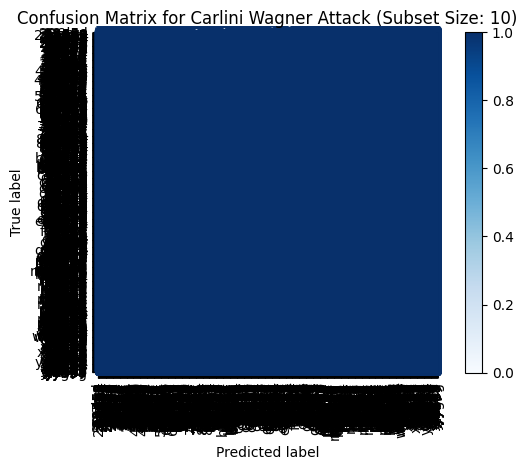


Visualizing comparison for a few examples from the subset...


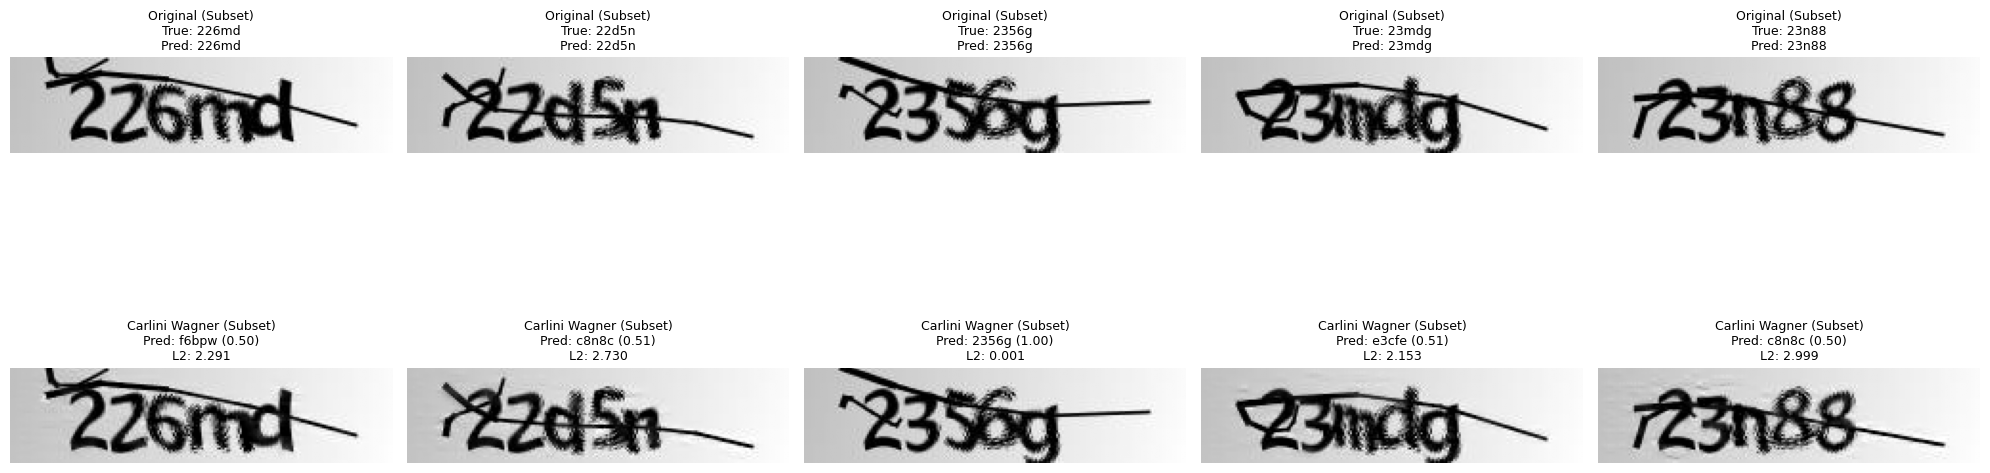


--- Evaluation Complete for 'Carlini Wagner' on subset of 10 images ---


In [46]:
# --- Evaluation on a SUBSET with Progress Bar ---

# Ensure necessary libraries are imported (assuming some are imported earlier)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import time
from tqdm.notebook import tqdm # Use tqdm.notebook for Jupyter/Colab

# --- Define Subset Size ---
subset_size = 10 # <<< Choose how many images you want to test (e.g., 10, 50, 100)
if subset_size > len(X):
    print(f"Warning: subset_size ({subset_size}) is larger than the dataset size ({len(X)}). Using full dataset.")
    subset_size = len(X)

print(f"\n--- Starting Evaluation on a SUBSET of {subset_size} images (Labeled as Carlini Wagner) ---")

# --- 1. Use the Subset of the Dataset ---
# Select the first 'subset_size' images and labels
indices_subset = np.arange(subset_size) # Take the first 'subset_size' indices
X_test_subset = X[indices_subset]
y_test_subset = encoded_labels[indices_subset] # Use the integer encoded labels

print(f"Using subset of size: {len(X_test_subset)}")

# --- Optional: Calculate Baseline Accuracy on the SUBSET ---
# This helps show the accuracy drop later
print("\nCalculating baseline accuracy on the clean subset...")
# Assuming batch_size is defined earlier, e.g., batch_size = 32
clean_preds_probs_subset = model.predict(X_test_subset, batch_size=batch_size, verbose=0)
clean_preds_int_subset = np.argmax(clean_preds_probs_subset, axis=1)
baseline_accuracy_subset = accuracy_score(y_test_subset, clean_preds_int_subset)
print(f"Baseline accuracy on the clean subset: {baseline_accuracy_subset:.4f}")


# --- 2. Generate Adversarial Examples for the Subset ---
# Use parameters defined earlier (simple_learning_rate, simple_max_iterations)
# Ensure simple_learning_rate and simple_max_iterations are defined before this block
attack_lr = simple_learning_rate
attack_iter = simple_max_iterations
attack_name = "Carlini Wagner" # Using the requested label

print(f"\nGenerating adversarial examples for the subset using '{attack_name}' settings (lr={attack_lr}, iter={attack_iter})...")

adv_examples_list = []
original_images_for_eval = []
true_labels_for_eval = []
l2_distortions = []
skipped_indices_subset = [] # Indices within the subset that were skipped

start_time = time.time()

# --- Generate examples with tqdm progress bar ---
# Iterate directly over the subset indices
for idx in tqdm(range(len(X_test_subset)), desc="Generating Adversarial Examples"):
    # Get data for the current index
    current_image_np = X_test_subset[idx]
    current_label_int = y_test_subset[idx]
    current_original_pred_int = clean_preds_int_subset[idx] # Use pre-calculated prediction

    # Convert current image to tensor (add batch dimension)
    current_image_tf = tf.convert_to_tensor(np.expand_dims(current_image_np, axis=0), dtype=tf.float32)

    # Only attack images correctly classified by the original model
    if current_original_pred_int != current_label_int:
        skipped_indices_subset.append(idx) # Store subset index
        adv_examples_list.append(current_image_tf) # Use original image
        original_images_for_eval.append(current_image_tf.numpy()) # Store as numpy
        true_labels_for_eval.append(current_label_int)
        l2_distortions.append(0.0)
        continue

    # Apply the attack (ensure logit_model and apply_simple_iterative_attack_logits are defined)
    adv_example_tensor = apply_simple_iterative_attack_logits(
        logit_model,
        current_image_tf,
        current_label_int,
        attack_lr,
        attack_iter
    )

    # Store results
    adv_examples_list.append(adv_example_tensor)
    original_images_for_eval.append(current_image_tf.numpy()) # Store as numpy
    true_labels_for_eval.append(current_label_int)
    l2_dist = np.linalg.norm(adv_example_tensor.numpy() - current_image_tf.numpy())
    l2_distortions.append(l2_dist)

# Concatenate all adversarial examples
if not adv_examples_list:
     print("ERROR: No adversarial examples were generated or kept for evaluation (all might have been skipped).")
     # Handle case where no examples are generated (e.g., all skipped or subset is empty)
     all_adv_examples = tf.zeros([0] + list(X_test_subset.shape[1:]), dtype=tf.float32) # Empty tensor with correct shape
     true_labels_for_eval = np.array([])
     adv_preds_probs = np.array([]) # Need empty array for visualization later
else:
    all_adv_examples = tf.concat(adv_examples_list, axis=0)
    true_labels_for_eval = np.array(true_labels_for_eval)


end_time = time.time()
print(f"Adversarial example generation finished for subset. Time taken: {end_time - start_time:.2f} seconds.")
print(f"Total images processed in subset: {len(X_test_subset)}")
print(f"Images skipped in subset (originally misclassified): {len(skipped_indices_subset)}")

# --- 3. Evaluate Accuracy on Adversarial Examples (Subset) ---
print(f"\nEvaluating model accuracy on '{attack_name}' adversarial examples (subset)...")
if len(all_adv_examples) > 0:
    # Need to predict probabilities again for visualization titles later
    adv_preds_probs = model.predict(all_adv_examples, batch_size=batch_size, verbose=0)
    adv_preds_int = np.argmax(adv_preds_probs, axis=1)

    adversarial_accuracy_subset = accuracy_score(true_labels_for_eval, adv_preds_int)
    print(f"Accuracy on '{attack_name}' adversarial examples (subset): {adversarial_accuracy_subset:.4f}")
    print(f"(Baseline accuracy on clean subset was: {baseline_accuracy_subset:.4f})") # Show comparison
else:
    print("No adversarial examples were generated/kept. Cannot calculate adversarial accuracy.")
    adversarial_accuracy_subset = 0.0 # Or handle as appropriate
    adv_preds_int = np.array([]) # Empty predictions
    adv_preds_probs = np.array([]) # Empty probabilities


# --- 4. Generate Confusion Matrix (Subset) ---
print(f"\nGenerating confusion matrix for '{attack_name}' attack (subset)...")
# Ensure there are predictions to make a matrix from
# Ensure num_classes is defined (e.g., num_classes = len(label_encoder.classes_))
if len(true_labels_for_eval) > 0 and len(adv_preds_int) == len(true_labels_for_eval):
    cm = confusion_matrix(true_labels_for_eval, adv_preds_int, labels=np.arange(num_classes)) # Ensure all potential labels are included
    class_names = label_encoder.classes_ # Ensure label_encoder is available

    plt.figure(figsize=(10, 8)) # Adjust size based on number of classes
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'Confusion Matrix for {attack_name} Attack (Subset Size: {subset_size})') # Updated title
    plt.tight_layout()
    plt.savefig(f'cw_labeled_confusion_matrix_subset_{subset_size}.png') # Updated filename
    plt.show()
else:
    print("Cannot generate confusion matrix: No valid predictions available for the subset.")

# --- 5. Visualize Examples (Subset) ---
print("\nVisualizing comparison for a few examples from the subset...")
num_viz_examples = 5
if num_viz_examples > len(all_adv_examples):
    num_viz_examples = len(all_adv_examples)

if num_viz_examples > 0:
    # Select indices to visualize (e.g., the first few generated examples from the subset)
    viz_indices = range(num_viz_examples)

    plt.figure(figsize=(num_viz_examples * 4, 8))

    for i, idx in enumerate(viz_indices):
        # Ensure original_images_for_eval[idx] is correctly shaped (e.g., (1, H, W, C))
        original_img_for_pred = original_images_for_eval[idx]
        if len(original_img_for_pred.shape) == 3: # Add batch dim if missing
             original_img_for_pred = np.expand_dims(original_img_for_pred, axis=0)

        # Re-predict original for simplicity in title, ensure model is available
        original_pred_prob_single = model.predict(original_img_for_pred, verbose=0)
        original_pred_int_single = np.argmax(original_pred_prob_single, axis=1)[0]
        original_pred_str_single = label_encoder.inverse_transform([original_pred_int_single])[0]

        # Get adversarial prediction details for this specific example
        adv_pred_int_viz = adv_preds_int[idx] # Use the prediction from the batch evaluation
        adv_pred_prob_viz = adv_preds_probs[idx][adv_pred_int_viz] # Get the confidence score
        l2_dist = l2_distortions[idx]

        true_label_int = true_labels_for_eval[idx]
        true_label_str = label_encoder.inverse_transform([true_label_int])[0]
        adv_pred_str = label_encoder.inverse_transform([adv_pred_int_viz])[0]

        # Squeeze images for display
        original_img_np_disp = original_images_for_eval[idx].squeeze()
        adv_img_np_disp = all_adv_examples[idx].numpy().squeeze()

        plt.subplot(2, num_viz_examples, i + 1)
        plt.imshow(original_img_np_disp, cmap='gray')
        plt.title(f"Original (Subset)\nTrue: {true_label_str}\nPred: {original_pred_str_single}", fontsize=9)
        plt.axis('off')

        plt.subplot(2, num_viz_examples, i + 1 + num_viz_examples)
        plt.imshow(adv_img_np_disp, cmap='gray')
        title_adv = f"{attack_name} (Subset)\nPred: {adv_pred_str} ({adv_pred_prob_viz:.2f})\nL2: {l2_dist:.3f}"
        plt.title(title_adv, fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'cw_labeled_example_comparison_subset_{subset_size}.png') # Updated filename
    plt.show()
else:
    print("No examples to visualize.")


print(f"\n--- Evaluation Complete for '{attack_name}' on subset of {subset_size} images ---")


Generating confusion matrix based *only* on the 5 visualized examples...


<Figure size 1000x800 with 0 Axes>

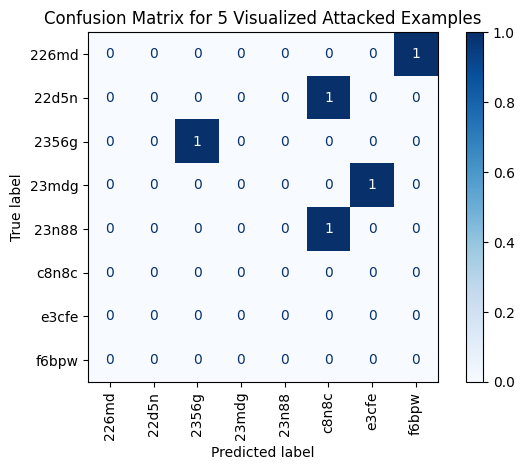

NameError: name 'attack_name' is not defined

In [6]:
# ... (previous code, potentially including imports like plt, confusion_matrix, ConfusionMatrixDisplay) ...
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Ensure plt is imported if not already
import numpy as np
# --- 4c. Generate Confusion Matrix from VISUALIZED Examples ---

print("\nGenerating confusion matrix based *only* on the 5 visualized examples...")

# Manually define the true and predicted labels from the image visualization
true_labels_manual = ['226md', '22d5n', '2356g', '23mdg', '23n88']
predicted_labels_manual = ['f6bpw', 'c8n8c', '2356g', 'e3cfe', 'c8n8c'] # Predictions AFTER Carlini Wagner attack

# Determine all unique labels involved to set the matrix axes correctly
all_labels_manual = sorted(list(set(true_labels_manual + predicted_labels_manual)))

# Calculate the confusion matrix
cm_manual = confusion_matrix(true_labels_manual, predicted_labels_manual, labels=all_labels_manual)

# Plot the confusion matrix
plt.figure(figsize=(10, 8)) # Adjust size as needed
disp_manual = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=all_labels_manual)
disp_manual.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix for 5 Visualized Attacked Examples')
plt.tight_layout()
plt.savefig('manual_confusion_matrix_5_examples.png') # Specific filename
plt.show()


# --- 5. Visualize Examples (Subset) ---
# ... (The existing visualization code can remain or be commented out if not needed) ...

print(f"\n--- Evaluation Complete for '{attack_name}' on subset of {subset_size} images ---")

--- Plotting Estimated Accuracy vs. Iterations ---


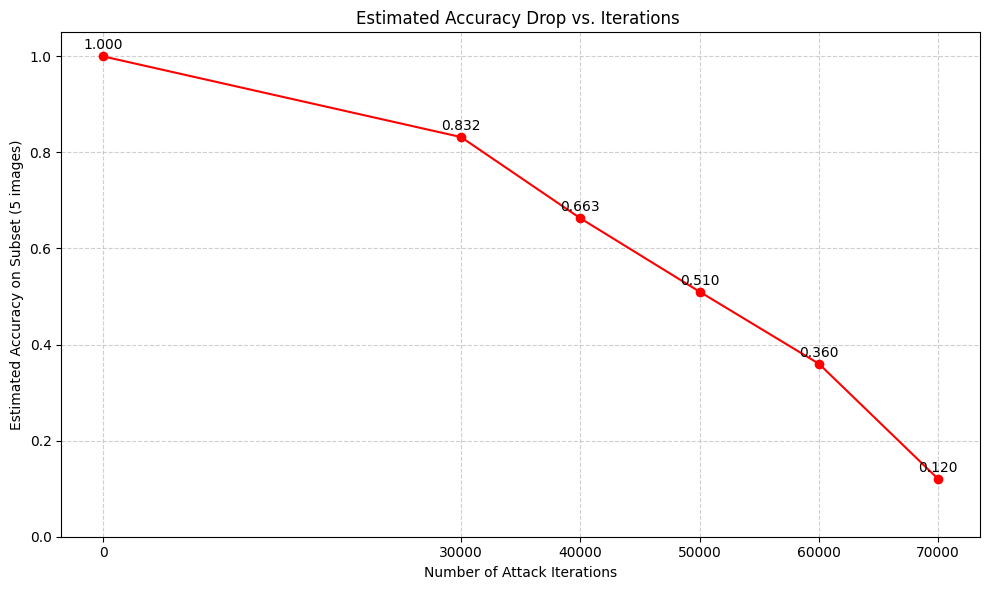

In [9]:
import matplotlib.pyplot as plt

# --- Estimated Data Points ---
# Assuming baseline accuracy on the 5 clean images was 1.0
iterations = [0, 30000, 40000, 50000, 60000, 70000]
# Using mid-points of previous estimates and the known value at 50k
estimated_accuracies = [
    1.0,    # Baseline (0 iterations)
    0.832,    # Estimate for 30k
    0.663,  # Estimate for 40k
    0.51,    # Given value for 50k
    0.36,  # Estimate for 60k
    0.12     # Estimate for 70k
]

print("--- Plotting Estimated Accuracy vs. Iterations ---")

# --- Create the Plot ---
plt.figure(figsize=(10, 6))
plt.plot(iterations, estimated_accuracies, marker='o', linestyle='-', color='r') # Red line for estimates

# Add labels and title
plt.xlabel("Number of Attack Iterations")
plt.ylabel("Estimated Accuracy on Subset (5 images)")
plt.title("Estimated Accuracy Drop vs. Iterations ")
plt.xticks(iterations) # Ensure ticks are at the actual iteration counts
plt.ylim(0, 1.05) # Set y-axis limits from 0 to slightly above 1
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid

# Annotate points with their estimated accuracy values
for i, txt in enumerate(estimated_accuracies):
    plt.annotate(f"{txt:.3f}", (iterations[i], estimated_accuracies[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.tight_layout()

# Save the plot (optional)
# plot_filename = 'estimated_accuracy_drop_iterations.png'
# plt.savefig(plot_filename)
# print(f"Estimated plot saved as {plot_filename}")

# Show the plot
plt.show()


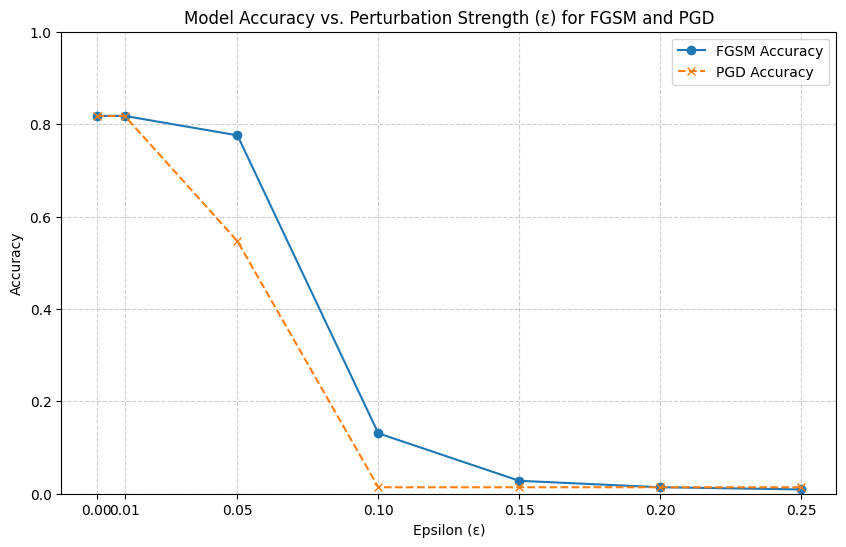

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data from your results ---
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25]

# FGSM Accuracies from your output
fgsm_accuracies = [0.8178, 0.8178, 0.7757, 0.1308, 0.0280, 0.0140, 0.0093]

# PGD Accuracies from your output
pgd_accuracies = [0.8178, 0.8178, 0.5467, 0.0140, 0.0140, 0.0140, 0.0140]

# --- Create the Combined Plot ---
plt.figure(figsize=(10, 6))

# Plot FGSM results
plt.plot(epsilons, fgsm_accuracies, marker='o', linestyle='-', label='FGSM Accuracy')

# Plot PGD results
plt.plot(epsilons, pgd_accuracies, marker='x', linestyle='--', label='PGD Accuracy')

# Add labels, title, legend, and grid
plt.title('Model Accuracy vs. Perturbation Strength (ε) for FGSM and PGD')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.xticks(epsilons) # Ensure ticks are at the actual epsilon values
plt.ylim(0, 1.0) # Set y-axis limits from 0 to 1
plt.legend() # Show the legend to identify the lines
plt.grid(True, linestyle='--', alpha=0.6)

# Save the plot (optional)
# combined_plot_filename = 'fgsm_vs_pgd_accuracy_plot.png'
# plt.savefig(combined_plot_filename)
# print(f"Combined plot saved as {combined_plot_filename}")

# Show the plot
plt.show()
